# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 
 Цель : научиться определять рыночную стоимость объектов недвижимости. 
Необходимо провести исследовательский анализ данных, который поможет установить параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

## Загрузка данных.

Импортируем библиотеки и читаем файл с таблицей, сохраняем его в переменную.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

Смотрим общую информацию о таблице.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Проверяем кол-во явных дубликатов. Их нет.

In [16]:
data.duplicated().sum()

0

Построение гистограммы для всех числовых столбцов таблицы.

<function matplotlib.pyplot.show(close=None, block=None)>

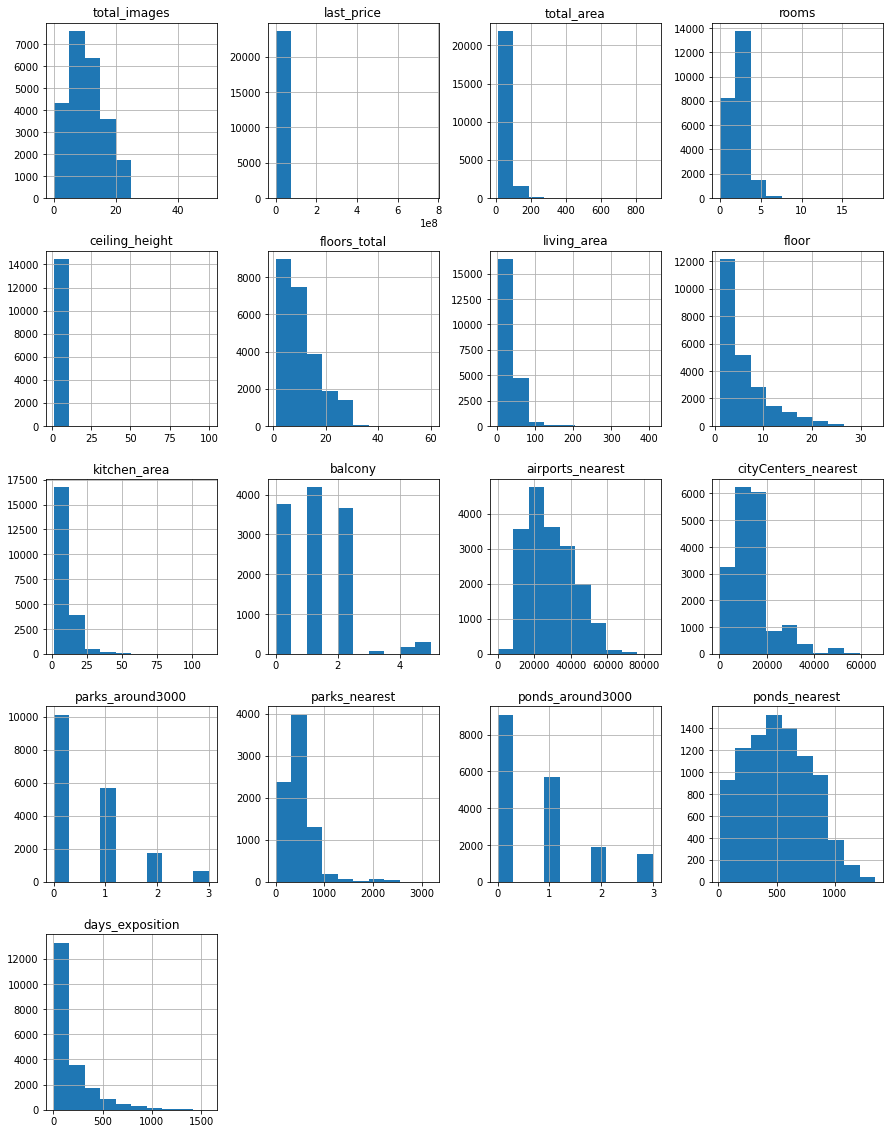

In [17]:
data.hist(figsize=(15,20))
plt.show

При первичном знакомстве с данными мы видим , что есть пропуски, отсутсвуют явные дубликаты. </font>

### Предобработка данных

Изучение пропусков в данных

In [18]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Заполнение всех пропусков в столбце балкон - '0'. Скорее всего , если человек не указал кол-во балконов - их нет. 

In [19]:
data['balcony'] = data['balcony'].fillna(0)

Пропуски высоты потолков можно заполнить медиальным значением для всего столбца.

In [20]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Заполняем пропущенные значения жилой площади медиальным отношением жилой площади к общей площади для пропущенных значений.

In [21]:
data.loc[data['living_area'].isna(), 'living_area'] = (data['living_area'] / data['total_area']).median() * data.loc[data['living_area'].isna(), 'total_area']

Для пропущенных значений в площади кухни делаем тоже самое.

In [22]:
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = (data['kitchen_area'] / data['total_area']).median() * data.loc[data['kitchen_area'].isna(), 'total_area']

В тех строках, где кол-во комнат равно нулю, заполняем пропуски для столбца с апартаментами 'True', в остальных 'False'.

In [23]:
data.loc[(data['rooms'] == 0)&(data['is_apartment'].isna()), 'is_apartment']  = data.fillna(True)

In [24]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Пропуски общего кол-ва этажей заполним медиальным отношением общего кол-ва этажей к этажу самой квартиры.

In [25]:
data.loc[data['floors_total'].isna(), 'floors_total'] = (data['floors_total'] / data['floor']).median() * data.loc[data['floors_total'].isna(), 'floor']

Удаляем пропуски в названии населенного пункта.

In [26]:
data = data.dropna(subset=['locality_name'])

Проверяем результат, в основных категориях больше не осталось пропусков. 
Оставшиеся пропуски оставим как есть, они не повлияют на дальнейшее исследование.

In [27]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

Пропуски в данных могут быть результатом нескольких факторов: <br>
1. Произошел технический сбой при обработке или хранении данных.
2. Пропуски в данных могут быть результатом человеческой ошибки(неправильно внесли данные).
3. Скорее всего пропуски связанны с некоректной системой сбора данных, например пользователь не обязан заполнить все поля для оформления обьявления.

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Смотрим на формат записи даты и времени.

In [29]:
data['first_day_exposition'].head(20)

0     2019-03-07T00:00:00
1     2018-12-04T00:00:00
2     2015-08-20T00:00:00
3     2015-07-24T00:00:00
4     2018-06-19T00:00:00
5     2018-09-10T00:00:00
6     2017-11-02T00:00:00
7     2019-04-18T00:00:00
8     2018-05-23T00:00:00
9     2017-02-26T00:00:00
10    2017-11-16T00:00:00
11    2018-08-27T00:00:00
12    2016-06-30T00:00:00
13    2017-07-01T00:00:00
14    2016-06-23T00:00:00
15    2017-11-18T00:00:00
16    2017-11-23T00:00:00
17    2016-09-09T00:00:00
18    2017-01-27T00:00:00
19    2019-01-09T00:00:00
Name: first_day_exposition, dtype: object

Меняем формат записи даты и времени и смотрим на результат.
Нужно было поменять формат времени с 'object' на 'datetime64' для того, чтобы впоследствии была возможность добавить новые столбцы(день недели,месяц,год).

In [30]:
data._is_copy = None
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [31]:
data['first_day_exposition'].head(20)

0    2019-03-07
1    2018-12-04
2    2015-08-20
3    2015-07-24
4    2018-06-19
5    2018-09-10
6    2017-11-02
7    2019-04-18
8    2018-05-23
9    2017-02-26
10   2017-11-16
11   2018-08-27
12   2016-06-30
13   2017-07-01
14   2016-06-23
15   2017-11-18
16   2017-11-23
17   2016-09-09
18   2017-01-27
19   2019-01-09
Name: first_day_exposition, dtype: datetime64[ns]

Выявляем неявные дубликаты в названиях населенных пунктов и приводим их одному формату.

In [32]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','городской поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции','поселок станции')
data['locality_name'] = data['locality_name'].str.replace('деревня','село')


In [33]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'село Кудрово', 'Коммунар', 'Колпино',
       'городской поселок Красный Бор', 'Гатчина', 'село Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'село Новое Девяткино',
       'поселок Металлострой', 'городской поселок Лебяжье',
       'городской поселок Сиверский', 'поселок Молодцово',
       'городской поселок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск', 'село Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'село Куттузи', 'поселок Аннино', 'городской поселок Ефимовский',
       'поселок Плодовое', 'село Заклинье', 'поселок Торковичи',
       'поселок Первомайское', 'Красное Село', 'поселок Понтонный',
       'Сясьстрой', 'село Старая', 'село Лесколово', 'поселок Новый Свет',
       'Сланцы', 'село Путилово', 'Ивангород', 'Мурино', 'Шлиссел

In [34]:
len(data) # сколько строк осталось после предобработки

23650

В ходе предобработки были выполненны следующие шаги: 
1. Обнарауженны и заполненны пропуски там, где это было возможно.
2. Был изменен тип данных для формата записи времени.
3. Были обнаруженны и исправленны неявные дубликаты в названиях населенных пунктов.

### Посчитайте и добавьте в таблицу новые столбцы

# Добавляем новые столбцы

Столбец с ценой квадратного метра

In [35]:
data['square_meter_price'] = (data['last_price'] / data['total_area']).round(2)

In [36]:
data['square_meter_price'].head()

0    120370.37
1     82920.79
2     92785.71
3    408176.10
4    100000.00
Name: square_meter_price, dtype: float64

Столбец с днем недели размещения объявления.

In [37]:
data['expositions_weekday'] = data['first_day_exposition'].dt.weekday

In [38]:
data['expositions_weekday'].head()

0    3
1    1
2    3
3    4
4    1
Name: expositions_weekday, dtype: int64

Столбец с месяцом размещения.

In [39]:
data['expositions_month'] = data['first_day_exposition'].dt.month

In [40]:
data['expositions_month'].head()

0     3
1    12
2     8
3     7
4     6
Name: expositions_month, dtype: int64

Столбец с годом размещения.

In [41]:
data['expositions_year'] = data['first_day_exposition'].dt.year

In [42]:
data['expositions_year'].head()

0    2019
1    2018
2    2015
3    2015
4    2018
Name: expositions_year, dtype: int64

Столбец с обозначением типа этажа : 'первый' , 'последний' , 'другой'.

In [43]:
def floorstype(row) : 
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else: 
        return 'другой'
data['floor_type'] = data.apply(floorstype, axis=1)    

In [44]:
data['floor_type'].head()

0    другой
1    первый
2    другой
3    другой
4    другой
Name: floor_type, dtype: object

Столбец с расстоянием до центра города в км.

In [45]:
data['city_center_km'] = round(data['cityCenters_nearest']/1000)

In [46]:
data['city_center_km'].head()

0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
Name: city_center_km, dtype: float64

### Проведите исследовательский анализ данных

Изучим столбец с общей площадью квартиры.

In [47]:
data['total_area'].describe()

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

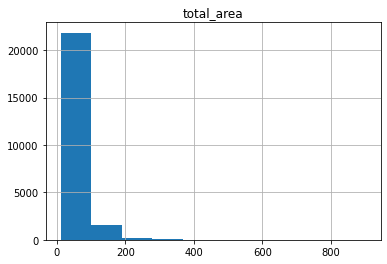

In [48]:
data['total_area'].hist()
plt.title('total_area')
plt.show()

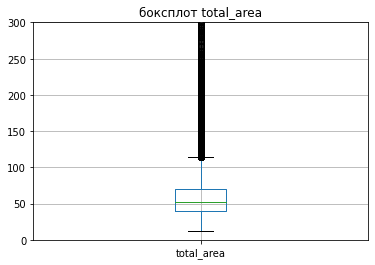

In [49]:
plt.ylim(0,300)
data.boxplot(column='total_area')
plt.title('боксплот total_area')
plt.show()

In [50]:
data[data['total_area'] > 250]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,expositions_weekday,expositions_month,expositions_year,floor_type,city_center_km
155,8,96000000.0,317.0,2017-07-07,4,3.50,3.0,183.000000,3,False,...,508.0,3.0,366.0,62.0,302839.12,4,7,2017,последний,2.0
464,15,66571000.0,280.3,2015-06-11,6,5.20,8.0,159.500000,7,False,...,187.0,1.0,616.0,578.0,237499.11,3,6,2015,другой,7.0
581,20,65000000.0,365.0,2019-03-18,7,2.90,7.0,207.268863,7,False,...,378.0,3.0,58.0,NaN,178082.19,0,3,2019,последний,2.0
660,3,49950000.0,483.9,2017-10-04,7,3.20,6.0,312.500000,4,False,...,461.0,3.0,22.0,391.0,103223.81,2,10,2017,другой,1.0
793,20,135000000.0,310.0,2018-05-22,4,3.30,5.0,250.000000,2,False,...,295.0,3.0,190.0,342.0,435483.87,1,5,2018,другой,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22238,12,19500000.0,287.5,2017-12-27,7,2.65,4.0,183.700000,3,False,...,578.0,1.0,853.0,90.0,67826.09,2,12,2017,другой,5.0
22345,8,53250000.0,290.0,2017-09-25,6,2.90,7.0,180.000000,6,False,...,427.0,0.0,NaN,134.0,183620.69,0,9,2017,другой,6.0
22494,7,91075000.0,491.0,2017-05-27,5,4.20,9.0,274.000000,9,False,...,116.0,0.0,NaN,115.0,185488.80,5,5,2017,последний,6.0
22835,20,29000000.0,275.0,2018-07-27,5,2.65,17.0,180.000000,17,False,...,570.0,3.0,502.0,91.0,105454.55,4,7,2018,последний,13.0


Видно , что в данных есть выбросы. Они плохо повлияют на результат исследования. Оставим только те квартиры , плозадь которых меньше 250 кв.м . 112 строк придется удалить, это незначительная часть данных.

In [51]:
data = data.loc[data['total_area'] < 250]

In [52]:
data['total_area'].describe()

count    23534.000000
mean        58.933078
std         28.782378
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        249.900000
Name: total_area, dtype: float64

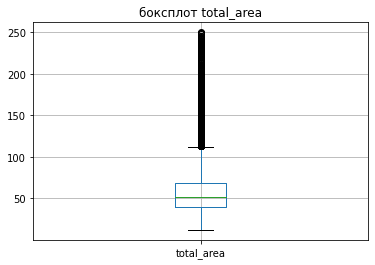

In [53]:
data.boxplot(column='total_area')
plt.title('боксплот total_area')
plt.show()

Посмотрим на жилую площадь.

In [54]:
data['living_area'].describe()

count    23534.00000
mean        33.77112
std         18.77799
min          2.00000
25%         19.00000
50%         30.00000
75%         42.00000
max        220.00000
Name: living_area, dtype: float64

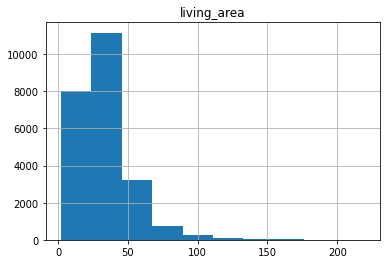

In [55]:
data['living_area'].hist()
plt.title('living_area')
plt.show()

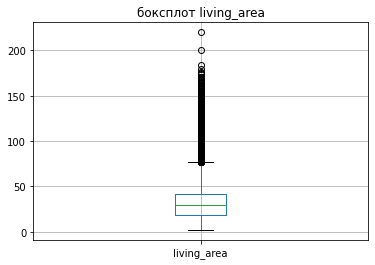

In [56]:
data.boxplot(column='living_area')
plt.title('боксплот living_area')
plt.show()

Построем диграмму рассеяния. Поскольку жилая площадь напрямую зависит от общей площади.
Диаграмма показывает , что есть прямая зависимость между общей площадью и жилой. Следовательно данные в порядке.

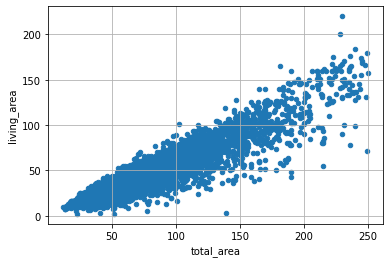

In [57]:
data.plot(x='total_area', y='living_area', grid=True, kind='scatter')
plt.show()

На графике видно, что от выбросов получилось избавиться.

Взглянем на площадь кухни.

In [58]:
data['kitchen_area'].describe()

count    23534.000000
mean        10.351154
std          5.531485
min          1.300000
25%          7.000000
50%          9.000000
75%         11.900000
max        107.000000
Name: kitchen_area, dtype: float64

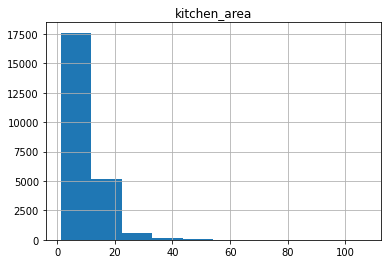

In [61]:
data['kitchen_area'].hist()
plt.title('kitchen_area')
plt.show()

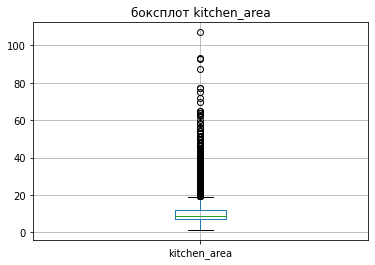

In [62]:
data.boxplot(column='kitchen_area')
plt.title('боксплот kitchen_area')
plt.show()

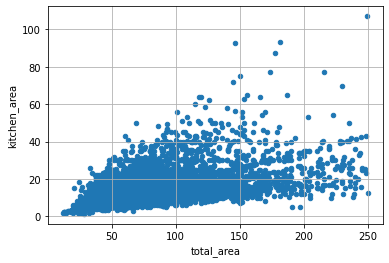

In [63]:
data.plot(x='total_area', y='kitchen_area', kind='scatter', grid=True)
plt.show()

Видим , что есть большие выбросы , которые могут испортить анализ. Оставим для исследования только те квартиры , где площадь кухни меньше 60 кв.м .

In [64]:
data = data[data['kitchen_area'] < 60]

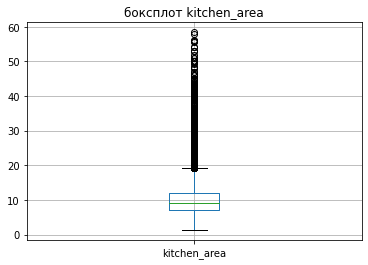

In [65]:
data.boxplot(column='kitchen_area')
plt.title('боксплот kitchen_area')
plt.show()

Сократили кол-во выбросов до приемлимого кол-ва.

Обратим свой взор на цену на момент снятия с публикации. Для удобства переведем цену в миллионы.

In [66]:
data._is_copy = None
data['last_price'] /= 1000000

In [67]:
data['last_price'].describe()

count    23517.000000
mean         6.153250
std          6.859093
min          0.012190
25%          3.400000
50%          4.600000
75%          6.700000
max        330.000000
Name: last_price, dtype: float64

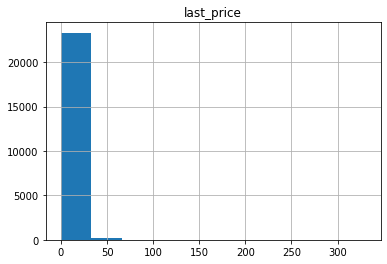

In [68]:
data['last_price'].hist()
plt.title('last_price')
plt.show()

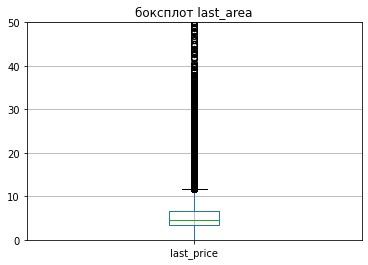

In [69]:
plt.ylim(0,50)
data.boxplot(column='last_price')
plt.title('боксплот last_area')
plt.show()

In [70]:
data[data['last_price'] > 40].count()

total_images            108
last_price              108
total_area              108
first_day_exposition    108
rooms                   108
ceiling_height          108
floors_total            108
living_area             108
floor                   108
is_apartment            108
studio                  108
open_plan               108
kitchen_area            108
balcony                 108
locality_name           108
airports_nearest        105
cityCenters_nearest     106
parks_around3000        106
parks_nearest            88
ponds_around3000        106
ponds_nearest            93
days_exposition          81
square_meter_price      108
expositions_weekday     108
expositions_month       108
expositions_year        108
floor_type              108
city_center_km          106
dtype: int64

Оставим только те квартиры , цена которых меньше 40000000 руб. , остальные придется удалить. Скорее всего это не типичная недвижимость. 
Если ее оставить она сильно исказит результаты исследования.

In [71]:
data = data.loc[data['last_price'] < 40]

In [72]:
len(data) # проверим сколько строк осталось в таблице

23400

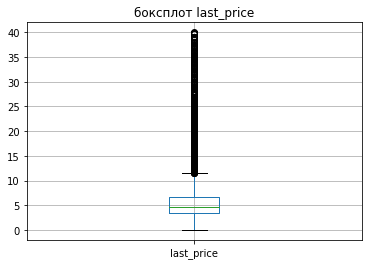

In [73]:
data.boxplot(column='last_price')
plt.title('боксплот last_price')
plt.show()

Обратимся к столбцы с кол-вом комнат.

In [74]:
data['rooms'].describe()

count    23400.000000
mean         2.040897
std          1.019278
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: rooms, dtype: float64

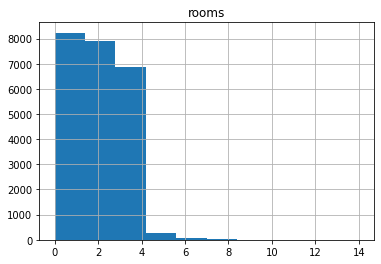

In [75]:
data['rooms'].hist()
plt.title('rooms')
plt.show()

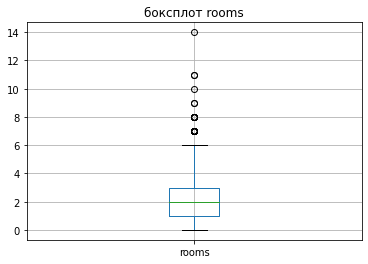

In [76]:
data.boxplot(column='rooms')
plt.title('боксплот rooms')
plt.show()

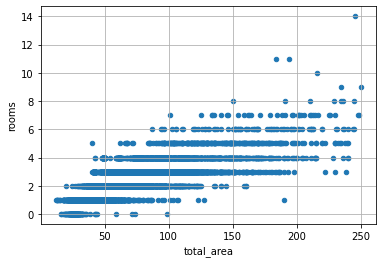

In [77]:
data.plot(x='total_area', y='rooms', kind='scatter', grid=True)
plt.show()

Оставим в таблице только те квартиры , где меньше 8 комнат.

In [78]:
data = data.loc[data['rooms'] < 8]

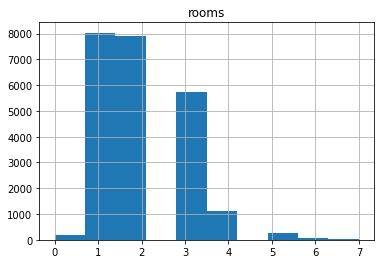

In [79]:
data['rooms'].hist()
plt.title('rooms')
plt.show()

Взглянем на высоту поталков.

In [80]:
data['ceiling_height'].describe()

count    23387.000000
mean         2.719904
std          0.992187
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

Видим , что в данных есть аномальные значения. Постараемся их исправить и оставить.

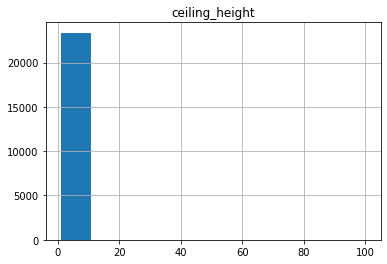

In [81]:
data['ceiling_height'].hist()
plt.title('ceiling_height')
plt.show()

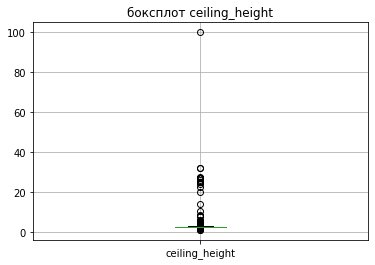

In [82]:
data.boxplot(column='ceiling_height')
plt.title('боксплот ceiling_height')
plt.show()

Заполним аномальные значения медиальными.

In [83]:
data._is_copy = None
data.loc[(data['ceiling_height'] < 2)|(data['ceiling_height'] > 3.5), 'ceiling_height'] = data['ceiling_height'].median()

In [84]:
data['ceiling_height'].describe()

count    23387.000000
mean         2.680320
std          0.172366
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          3.500000
Name: ceiling_height, dtype: float64

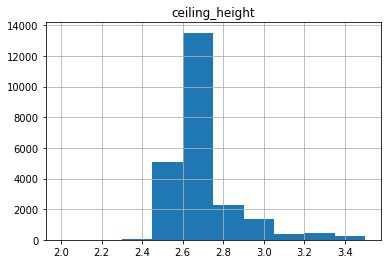

In [85]:
data['ceiling_height'].hist()
plt.title('ceiling_height')
plt.show()

Гистограмма для типа этажа.

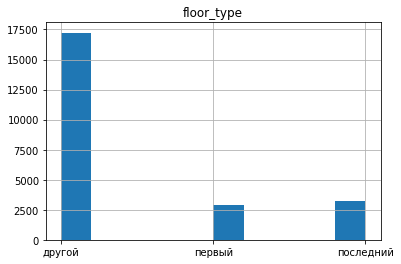

In [86]:
data['floor_type'].hist()
plt.title('floor_type')
plt.show()

Общее кол-во этажей.

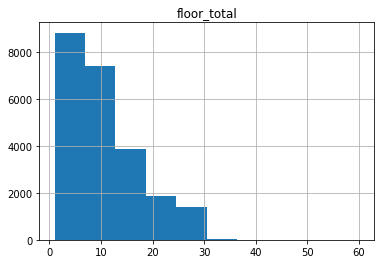

In [87]:
data['floors_total'].hist()
plt.title('floor_total')
plt.show()

In [88]:
data['floors_total'].describe()

count    23387.000000
mean        10.740642
std          6.639161
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Расстояние до центра города в метрах.

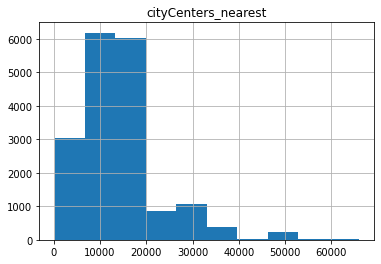

In [91]:
data['cityCenters_nearest'].hist()
plt.title('cityCenters_nearest')
plt.show()

In [92]:
data['cityCenters_nearest'].describe()

count    17881.000000
mean     14314.527040
std       8590.249231
min        181.000000
25%       9488.000000
50%      13171.000000
75%      16360.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Расстояние до ближайшего парка.

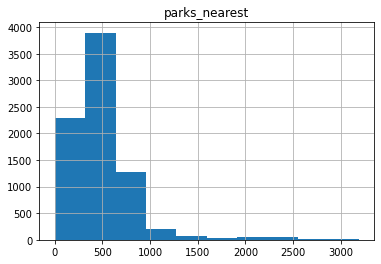

In [93]:
data['parks_nearest'].hist()
plt.title('parks_nearest')
plt.show()

# Изучим cколько дней было размещенно обьявление до снятия.

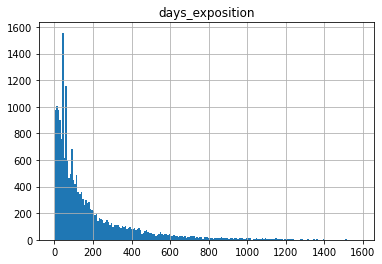

In [96]:
data['days_exposition'].hist(bins=200)
plt.title('days_exposition')
plt.show()

In [97]:
data['days_exposition'].describe()

count    20266.000000
mean       179.445574
std        218.526742
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

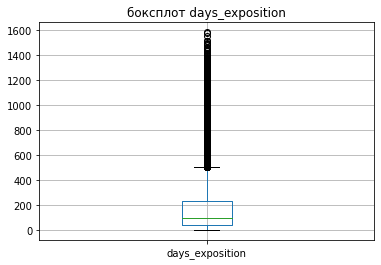

In [98]:
data.boxplot(column='days_exposition')
plt.title('боксплот days_exposition')
plt.show()

Видим , что есть выбросы. Возможно владелец забыл снять обьявление после продаже , также , возможно , это специфическая недвижимость и продается она не так быстро.

Среднее кол-во дней до снятия с публикации.

In [99]:
data['days_exposition'].mean()

179.44557386756142

Медиальное кол-во дней до снятия с публикации.

In [100]:
data['days_exposition'].median()

95.0

Можно считать продажи до месяца достаточно быстрыми. Продажи от 500 дней можно принять за слишком долгие.

# Изучим какие факторы больше всего влияют на общую (полную) стоимость объекта.

## Посмотрим как цена зависит от общей площади.

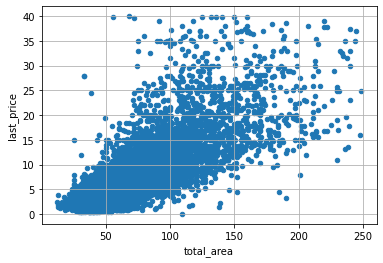

In [101]:
data.plot(x='total_area', y='last_price', grid=True, kind='scatter')
plt.show()

In [102]:
data['total_area'].corr(data['last_price']) #корелляция между общей площадью и ценой

0.7828123148392451

Мы видим ярко выраженную зависимоть между общей площадью и ценой продажи недвижимости.

## Изучим зависимость цены от жилой площади

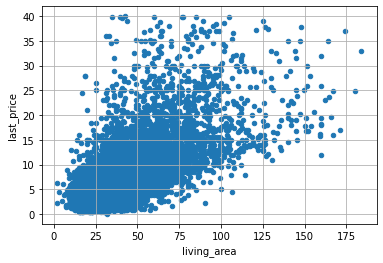

In [103]:
data.plot(x='living_area', y='last_price', kind='scatter', grid=True)
plt.show()

In [104]:
data['living_area'].corr(data['last_price']) #корелляция между жилой площадью и ценой

0.6840280563730513

Заметно, что карелляция жилой площади и ценой ниже чем общей площади. 

## Изучим зависимость цены и площади кухни.

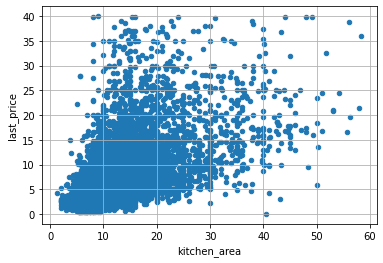

In [105]:
data.plot(x='kitchen_area', y='last_price', grid=True, kind='scatter')
plt.show()

In [106]:
data['kitchen_area'].corr(data['last_price']) #корелляция между площадью кухни и ценой

0.6165075003740805

Корелляция между ценой недвижимости и площадью кухни ниже чем у общей площади и жилой площади.

## Изучим есть ли связь между кол-вом комнат и ценой.

In [107]:
data['rooms'].corr(data['last_price'])

0.49787643567195744

Сводная таблица по кол-ву комнат и медиальной цене.

In [108]:
rooms_price_pivot = data.pivot_table(index='rooms', values='last_price', aggfunc='median')
rooms_price_pivot

,last_price
rooms,
0,2.700000
1,3.600000
2,4.752981
3,6.150000
4,8.822500
5,12.500000
6,16.495000
7,17.800000


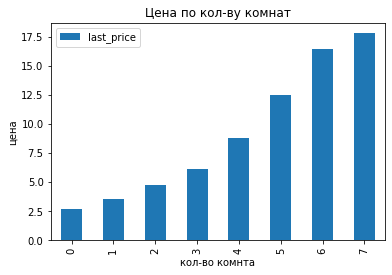

In [109]:
rooms_price_pivot.plot.bar()
plt.title('Цена по кол-ву комнат')
plt.xlabel('кол-во комнта')
plt.ylabel('цена')
plt.show()

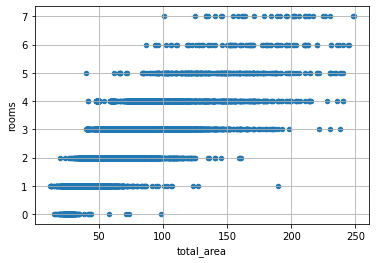

In [110]:
data.plot(x='total_area', y='rooms', kind='scatter', grid=True) #График зависимости площади от комнат.
plt.show()

Видно , что цена недвижимости повышается при увеличении числа комнат. Это связанно ,в основном, с увеличением общей площади недвижимости при увеличение кол-во комнат.

## Проверим , есть ли зависимость между типом этажа ('первый','последний','другой') и ценой.

Сделаем сводную таблицу , в которой будут медиальные значения цены недвижимости по типу этажа.

In [111]:
floor_type_price_pivot = data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
floor_type_price_pivot

,last_price
floor_type,
другой,4.80
первый,3.90
последний,4.25


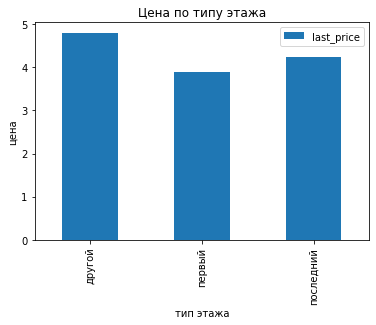

In [112]:
floor_type_price_pivot.plot.bar() #столбчатый график
plt.title('Цена по типу этажа')
plt.xlabel('тип этажа')
plt.ylabel('цена')
plt.show()

Благодоря таблице и столбчатому графику мы видим , что : 
    1. Первый этаж является самым дешевым.
    2. За ним идет последний этаж.
    3. Самыми дорогими являются этажи между первым и последним.

## Посмторим есть ли звязь между ценой и датой размещения(день недели, месяц, год).

### День недели и цена.

Сделаем сводную таблицу сгруппированную по дням недели и медиальным значением цены для каждого дня.

In [113]:
weekday_price_pivot = data.pivot_table(index='expositions_weekday', values='last_price', aggfunc='median')
weekday_price_pivot

,last_price
expositions_weekday,
0,4.60
1,4.70
2,4.67
3,4.60
4,4.55
5,4.50
6,4.50


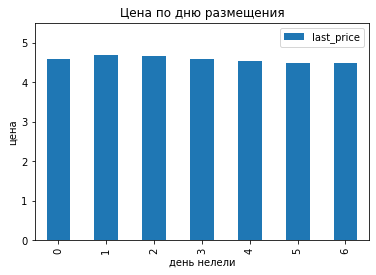

In [114]:
weekday_price_pivot.plot.bar(ylim=(0,5.5)) #столбчатый график
plt.title('Цена по дню размещения')
plt.xlabel('день нелели')
plt.ylabel('цена')
plt.show()

Мы можем увидеть , что цена практически не зависит от дня недели. Разве что к концу недели она ниже, но не значительно.

### Месяц и цена.

Сделаем сводную таблицу сгруппированную по месяцам и медиальным значением цены для каждого месяца.

In [115]:
month_price_pivot = data.pivot_table(index='expositions_month', values='last_price', aggfunc='median')
month_price_pivot

,last_price
expositions_month,
1,4.6000
2,4.6000
3,4.6225
4,4.7750
5,4.5000
6,4.3995
7,4.6000
8,4.5500
9,4.6500


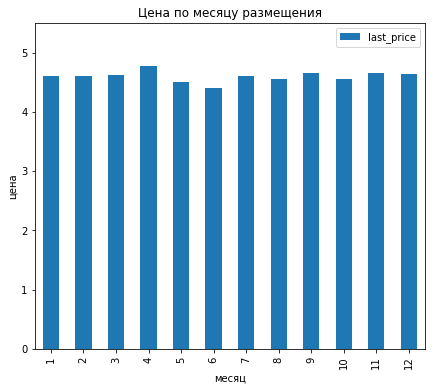

In [116]:
month_price_pivot.plot.bar(figsize=(7,6), ylim=(0,5.5)) #столбчатый график 
plt.title('Цена по месяцу размещения')
plt.xlabel('месяц')
plt.ylabel('цена')
plt.show()

Как и в случае с днями недели, значения от месяца к месяцу меняются не слишком сильно. Можно выделить только лишь июнь(6 месяц), цены в этом месяце ниже чем во всех остальных.

### Год и цена.

Сделаем сводную таблицу сгруппированную по году и медиальным значением цены для каждого года.

In [117]:
year_price_pivot = data.pivot_table(index='expositions_year', values='last_price', aggfunc='median')
year_price_pivot

,last_price
expositions_year,
2014,7.47656
2015,5.23450
2016,4.50000
2017,4.50000
2018,4.55000
2019,5.00000


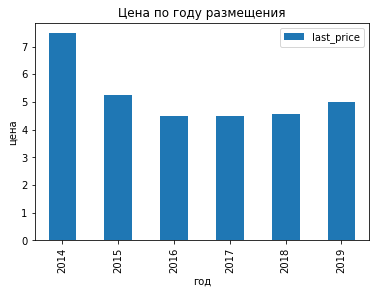

In [118]:
year_price_pivot.plot.bar() #столбчатый график.
plt.title('Цена по году размещения')
plt.xlabel('год')
plt.ylabel('цена')
plt.show()

Благодаря сводной таблице и столбчатому графику мы видим , что : 1. После 2014г цены на недвижимость значительно упали(7.5 млн. для 2014г). 2. После 2015г тоже заметно снижение цен, но уже не настолько резко(5.2 млн. 2015г). 3. В 2016г, 2017г, 2018г цены оставались примерно на одном уровне(4.5 млн.). 4. В 2019г цены немного выросли до 5 млн. , но так и не достигли показателей 2015г. <br> 
Остается не ясным с чем было связано такое резкое падение цен после 2014г (#возможно с политеческой обстановкой в стране :) #).
Можно сделать вывод , что цены начали медленно приходить в норму.


# Изучим 10 населённых пунктах с наибольшим числом объявлений.

Выделим населенные пункты с наибольшим кол-вом объявлений.

In [119]:
top_list  = data['locality_name'].value_counts().head(10).index
top_list

Index(['Санкт-Петербург', 'поселок Мурино', 'поселок Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'поселок Парголово', 'Гатчина', 'село Кудрово',
       'Выборг'],
      dtype='object')

Сводная таблица со средей ценой за кв.м для 10 нас. пунктов.

In [120]:
top_list_pivot = data.query('locality_name in @top_list').pivot_table(index='locality_name', values='square_meter_price')
top_list_pivot.sort_values(by='square_meter_price', ascending=False)

,square_meter_price
locality_name,
Санкт-Петербург,111644.020916
Пушкин,102929.680714
село Кудрово,92473.547559
поселок Парголово,90175.913089
поселок Мурино,85681.762572
поселок Шушары,78677.364318
Колпино,75333.295816
Гатчина,68746.146515
Всеволожск,68654.473970


Столбчатый график.

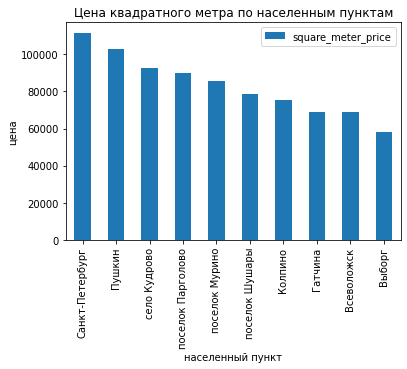

In [121]:
top_list_pivot.sort_values(by='square_meter_price', ascending=False).plot.bar() 
plt.title('Цена квадратного метра по населенным пунктам')
plt.xlabel('населенный пункт')
plt.ylabel('цена')
plt.show()

Как и ожидалось, в Санкт-Петербурге самая высокая цена за кв.м. , в Выборге самая низкая цена за кв.м.

# Исследуем как меняется цена недвижимости с каждым километром от центра Санкт-Петербурга.

Сделаем сводную таблицу для города Санкт_петербург. Группировка будет проходить по расстоянию от центра города в км. Посчитаем среднюю цена недвижимости для каждого км.

In [122]:
center_price_pivot = (
    data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='city_center_km', values='last_price', aggfunc='mean')
)
center_price_pivot

,last_price
city_center_km,
0.0,16.592878
1.0,12.175725
2.0,11.463611
3.0,9.916775
4.0,10.805913
5.0,11.294502
6.0,10.650525
7.0,10.658817
8.0,8.967440


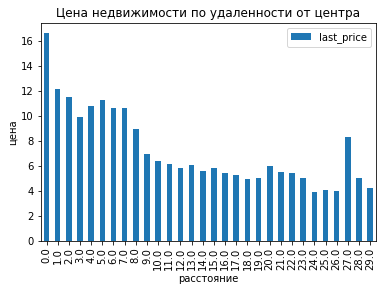

In [123]:
center_price_pivot.plot.bar() # столбчатый график
plt.title('Цена недвижимости по удаленности от центра')
plt.xlabel('расстояние')
plt.ylabel('цена')
plt.show()

На графике мы видим, что с большим отрывом самая дорогая недвижимость находится в самом центре города. По мере удаления от центра цена планомерно падает. Исключением является только 27 км , на которм цена находится примерно на уровне 8 км. С чем это связанно не ясно, возможно там распаложен какой то элитный район.

# Общий вывод

Для данного проекта были выполненны следующие шаги:
1. Обнарауженны и заполненны пропуски там, где это было возможно.
2. Был изменен тип данных для формата записи времени.
3. Были обнаруженны и исправленны неявные дубликаты в названиях населенных пунктов.
4. Также были добавлены новые столбцы (цена одного квадратного метра ,день недели публикации объявления ,месяц публикации объявления, год публикации объявления, тип этажа квартиры, расстояние до центра города в километрах).
5. Так же были обработаны редкие и аномальные значения , по возможности исправлены или удалены.
6. Выяснилось, что можно считать продажи до месяца достаточно быстрыми. Продажи от 500 дней можно принять за слишком долгие.
7. В ходе исследования было выявленны основные факторы влияющие на цену недвижимости : общая площадь недвижимости и жилая площадь.
8. Посчитали среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений, а так же где самая высокая и самая низкая цена цена за кв.м : в Санкт-Петербурге самая высокая цена за кв.м. , в Выборге самая низкая цена за кв.м.
9. Выявили , как меняется цена за кв.м в Санкт-Петербурге с каждым км от центра : с большим отрывом самая дорогая недвижимость находится в самом центре города. По мере удаления от центра цена планомерно падает. Исключением является только 27 км , на которм цена находится примерно на уровне 8 км. С чем это связанно не ясно, возможно там распаложен какой то элитный район.


# Рекомендации 

1. Нужно предзагрусить в систему названия всех нас. пунктов , что бы пользователь выбирал из них. Так можно будет избавиться от возникновения ниявных дубликатов в названиях.
2. Так же стоит исключить возможность появления пропусков в данных , например сделать все поля обязательными для заполнения.
3. Для самой антифрод-системы стоит разработать отдельный алгоритм для "не типичной недвижимости".